In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lets_plot import *

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
from matplotlib.figure import Figure
from matplotlib.axes import Axes

In [ ]:
import itertools

In [ ]:
def to_scalar(x, i):
    """Returns i-th element from an array x if x is array, else returns x
Args:
    x - input array
    i - index to return
Returns:
    x[i] if x is an array and x else
"""
    if isinstance(x, (np.ndarray, list)):
        return x[i]
    return x

In [ ]:
def gradient_checker(J, grad_J, theta, eps=1e-4, rtol=1e-5):
    """Gradient checker for scalar and vector functions
Args:
    J - function of theta
    grad_J - gradient of function J
    theta - the point for which to compute the numerical gradient
    eps - step value in numerical gradient
    rtol - relative tolerance threshold value
Returns:
    error message if the relative tolerance is greater for some axis
    or "Gradient check passed" else
"""
    it = np.nditer(theta, flags=['multi_index'], op_flags=['readwrite'])

    while not it.finished:
        ix = it.multi_index

        theta_ = np.array(theta, copy=True)
        theta_[ix] += eps
        np.random.seed(42)
        J1 = J(theta_)

        theta_ = np.array(theta, copy=True)
        theta_[ix] -= eps
        np.random.seed(42)
        J2 = J(theta_)

        J1 = to_scalar(J1, ix)
        J2 = to_scalar(J2, ix)

        num_grad = (J1 - J2)/(2*eps)

        rel_tol = np.abs(num_grad - grad_J(theta))[ix]/(1. + np.minimum(np.abs(num_grad), np.abs(grad_J(theta)[ix])))

        if np.all(rel_tol > rtol):
            print(f'Incorrect gradient for the axis {str(ix)}')
            return
        it.iternext()
    print(f'Gradient check passed')

In [ ]:
def J_theta_global(model, loss_function, theta, idx, x, y):
    previous = model.parameters()[idx].copy()
    np.copyto(dst=model.parameters()[idx], src=theta)
    outputs = model(x)
    loss = loss_function(outputs, y)
    np.copyto(dst=model.parameters()[idx], src=previous)
    return loss

In [ ]:
def dJ_theta_global(model, loss_function, theta, idx, x):
    grad = model.backward(loss_function)[idx] / x.shape[0]
    return grad.reshape(theta.shape)

In [ ]:
def sigmoid(x,slope=1.0):
    return 1.0/(1.0+np.exp(-slope*x))

In [ ]:
def sigmoid_prime(x,slope=1.0):
    return slope*sigmoid(x,slope=slope)*(1.0-sigmoid(x,slope=slope))

In [ ]:
z = np.random.normal(size=5)
gradient_checker(sigmoid, sigmoid_prime, z, eps=1e-4, rtol=1e-5)

Gradient check passed


In [ ]:
def gg_confusion_matrix(y, y_hat):
    conf_mat = confusion_matrix(y, y_hat)[::-1]
    confusion_dat = pd.DataFrame(conf_mat)
    observed = confusion_dat.columns.values
    actual = confusion_dat.index.values
    xx, yy = np.meshgrid(actual, observed)
    xx = xx.reshape(-1)
    yy = yy.reshape(-1)
    zz = conf_mat.reshape(-1)
    dat = {'predicted':xx, 'actual':yy[::-1], 'z':zz}
    p = ggplot(dat, aes('predicted', 'actual', fill='z')) \
        + geom_raster() \
        + geom_text(aes(label='z'), color='white')\
        + theme(legend_position='none', axis_ticks='blank', axis_line='blank')\
        + ggsize(500, 500) + scale_x_discrete() + scale_y_discrete()\
        + ggtitle('Confusion matrix')
    return p

In [ ]:
from matplotlib.figure import Figure
from matplotlib.axes import Axes

In [ ]:
import matplotlib.ticker as ticker

In [ ]:
import itertools

# RNN

In [ ]:
from copy import copy
import inspect
import functools

In [ ]:
from typing import List, Optional, Union, Callable
import json
import time

In [ ]:
num_examples = 1000
seq_len = 3
max_number = 10

In [ ]:
def get_examples(seq_len, num_examples, max_number):
    inputs = np.random.randint(0, max_number, size=(num_examples, seq_len))
    targets = np.sort(inputs)
    return inputs, targets

In [ ]:
inputs, targets = get_examples(seq_len, num_examples, max_number)

In [ ]:
for inp, tgt in zip(inputs[:10], targets[:10]):
    print(f'inputs/sorted: {list(inp), list(tgt)}')

inputs/sorted: ([6, 3, 7], [3, 6, 7])
inputs/sorted: ([4, 6, 9], [4, 6, 9])
inputs/sorted: ([2, 6, 7], [2, 6, 7])
inputs/sorted: ([4, 3, 7], [3, 4, 7])
inputs/sorted: ([7, 2, 5], [2, 5, 7])
inputs/sorted: ([4, 1, 7], [1, 4, 7])
inputs/sorted: ([5, 1, 4], [1, 4, 5])
inputs/sorted: ([0, 9, 5], [0, 5, 9])
inputs/sorted: ([8, 0, 9], [0, 8, 9])
inputs/sorted: ([2, 6, 3], [2, 3, 6])


In [ ]:
def to_string(X, seq_len, max_number):
    max_length = int(seq_len * np.ceil(np.log10(max_number + 1)) + seq_len - 1)
    Xstr = []
    for example in X:
        xstr = ','.join([str(n) for n in example])
        xstr += ''.join([' ' for _ in range(max_length - len(xstr))])
        Xstr.append(xstr)
    return Xstr

In [ ]:
inputs = to_string(inputs, seq_len, max_number)
targets = to_string(targets, seq_len, max_number)

In [ ]:
print(f'inputs[0]: {inputs[0]} targets[0]: {targets[0]}')

inputs[0]: 6,3,7    targets[0]: 3,6,7   


In [ ]:
vocab = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ',', ' ']

In [ ]:
def integer_encode(X, vocab):
    char_to_int = dict((c, i) for i, c in enumerate(vocab))
    Xenc = []
    for example in X:
        encoded = [char_to_int[char] for char in example]
        Xenc.append(encoded)
    return Xenc

In [ ]:
inputs = integer_encode(inputs, vocab)
targets = integer_encode(targets, vocab)

In [ ]:
print(f'inputs[0]: {inputs[0]} targets[0]: {targets[0]}')

inputs[0]: [6, 10, 3, 10, 7, 11, 11, 11] targets[0]: [3, 10, 6, 10, 7, 11, 11, 11]


In [ ]:
dataset_inputs = np.array(inputs)
dataset_targets = np.array(targets)

In [ ]:
from fast_deep_rnn.core import *

In [ ]:
class RNNCell(Module):
    def __init__(self, state_size: int, hidden_size: int):
        super().__init__()
        self.linear = LinearLayer(state_size, hidden_size)
        self.tanh = TanhFunction()
        self.hstack = HStack()
        self.register_parameters([self.linear])

    def forward(self, x: Tensor, h_t_1: Optional[Tensor] = None):
        X = self.hstack(x, h_t_1)
        z = self.linear(X)
        h_t = self.tanh(z)
        return h_t

In [ ]:
class RNN(Module):
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.state_size = input_size + hidden_size
        self.rnn = RNNCell(self.state_size, hidden_size)
        self. row = Row()
        self.vstack = VStack()
        self.register_parameters([self.rnn])

    def forward(self, x: Tensor, h_t_1: Optional[Tensor] = None):
        seq_len, batch_size, input_size = x.shape
        # print(f'seq_len: {seq_len} batch_size: {batch_size} input_size: {input_size}')
        h = Tensor(np.zeros((0, batch_size, self.hidden_size)), name="h")
        if h_t_1 is None:
            h_t_1 = Tensor(np.zeros((batch_size, self.hidden_size)), name="h_t_1")
        for idx in range(seq_len):
            h_t_1 = self.rnn.forward(self.row(x, idx), h_t_1)
            h = self.vstack(h, h_t_1.reshape((1, batch_size, self.hidden_size)))
        return h

In [ ]:
class RecurrentNetwork(Module):
    def __init__(self, vocab_size: int, emb_size: int, hidden_size: int):
        super().__init__()
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.embedding = Embedding(vocab_size, emb_size)
        self.rnn = RNN(emb_size, hidden_size)
        self.linear = LinearLayer(hidden_size, vocab_size)
        xavier_(self.linear.parameters)
        self.register_parameters([self.embedding, self.rnn, self.linear])

    def forward(self, x: Tensor):
        emb = self.embedding(x)
        rnn_out = self.rnn(emb)
        linear_out = self.linear(rnn_out.reshape(-1, self.hidden_size))
        return linear_out

In [ ]:
def eval_accuracy(model, val, y_val):
    model.eval()
    output = model(Tensor(val))
    y_hat = np.argmax(output.data, axis=1)
    model.train()
    return accuracy_score(y_val.ravel(), y_hat.ravel())

In [ ]:
num_epochs = 1
vocab_size = len(vocab)
emb_size = 20
hidden_size = 32
batch_size = 100
dataloader = DataLoader(dataset_inputs, dataset_targets, batch_size=batch_size)
model = RecurrentNetwork(vocab_size, emb_size, hidden_size)
loss_function = CrossEntropyLoss()
optimizer = SGD(model.parameters, lr=1.0)
# optimizer = Adam(model.parameters, alpha=0.1, beta1=0.9, beta2=0.999, eps=1e-8, weight_decay=0.01)
scheduler = ConstantLR(optimizer)

In [ ]:
model.size()

2332

In [ ]:
losses = []
accuracies = []
lrs = []
for epoch in range(num_epochs):
    loss_sum = 0
    for data in dataloader():
        optimizer.zero_grad()
        inputs, targets = data
        inputs = inputs.transpose(1, 0)
        targets = targets.transpose(1, 0)
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        loss_sum += loss.data
    acc = eval_accuracy(model, inputs.data, targets.data)
    print(f'\r epoch: [{epoch+1}/{num_epochs}], loss: {loss_sum}, acc: {acc}', end='')
    losses.append(loss_sum)
    accuracies.append(acc)
    lrs.append(scheduler.lr)
    scheduler.step()

 epoch: [1/1], loss: 16.662478383112063, acc: 0.675

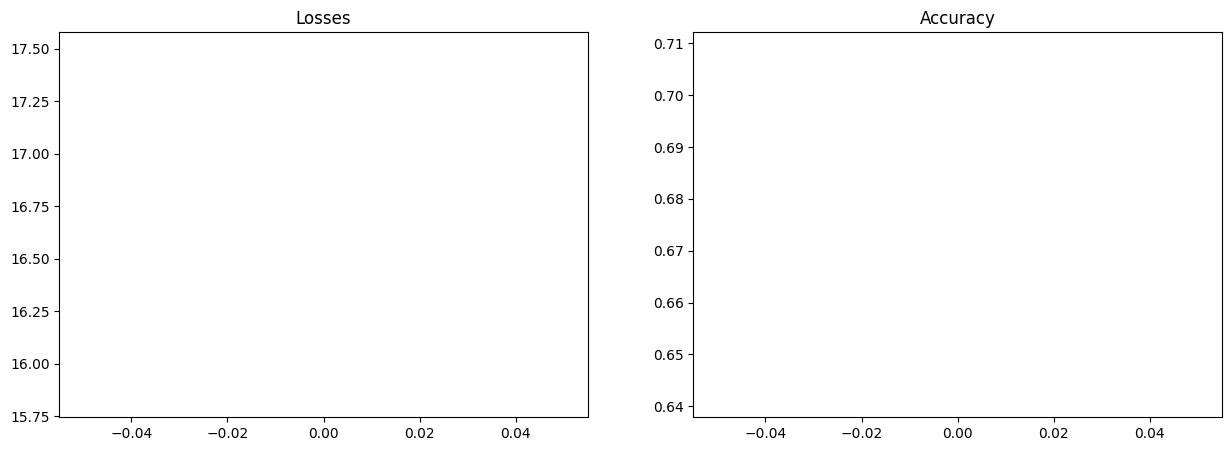

In [ ]:
epochs = np.arange(num_epochs)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(epochs, losses)
ax[0].set_title('Losses')
ax[1].plot(epochs, accuracies)
ax[1].set_title('Accuracy');

In [ ]:
# num_examples = 100
# seq_len = 3
# max_number = 10

# inputs, targets = get_examples(seq_len, num_examples, max_number)

# inputs = to_string(inputs, seq_len, max_number)
# targets = to_string(targets, seq_len, max_number)

# inputs = integer_encode(inputs, vocab)
# targets = integer_encode(targets, vocab)

# inputs, targets = Tensor(np.array(inputs).transpose((1, 0))), Tensor(np.array(targets).transpose((1, 0)))
# outputs = model(inputs)
# predicted = np.argmax(outputs.data, axis=1)

In [ ]:
# gg_confusion_matrix(targets.data.reshape(-1), predicted)

In [ ]:
num_examples = 100
seq_len = 2
max_number = 10
vocab_size = len(vocab)
emb_size = 20
hidden_size = 32

X_val, y_val = get_examples(seq_len, num_examples, max_number)
X_val, y_val = X_val.transpose(1, 0), y_val.transpose(1, 0)

In [ ]:
loss_function = CrossEntropyLoss()
model_ = RecurrentNetwork(vocab_size, emb_size, hidden_size)
dJ_theta_tensors = dJ_theta_global(model_, loss_function, Tensor(X_val), Tensor(y_val))
global_start = time.time()
for i, parameter in enumerate(model_.parameters):
    start = time.time()
    print(f'[{i}]: Start -- {parameter.__name__}')
    def J_theta(theta, idx=i, x=Tensor(X_val), y=Tensor(y_val)):
        return J_theta_global(model_, loss_function, theta, idx, x, y)
    gradient_checker(J_theta, dJ_theta_tensors[i], parameter.data)
    print(f'[{i}]: Elapsed time: {time.time() - start:.1f}s')
print(f'Total elapsed time: {time.time() - global_start:.1f}s')

[0]: Start -- E
Gradient check passed
[0]: Elapsed time: 0.7s
[1]: Start -- weights
Gradient check passed
[1]: Elapsed time: 3.9s
[2]: Start -- bias
Gradient check passed
[2]: Elapsed time: 0.1s
[3]: Start -- weights
Gradient check passed
[3]: Elapsed time: 0.7s
[4]: Start -- bias
Gradient check passed
[4]: Elapsed time: 0.0s
Total elapsed time: 5.4s


# 1. LSTM

### Problem 1 (6.0)(OK)

Implement the LSTM cell class and use it in the RNN sorter. Don't forget to check gradients!

LSTM cell formulas:
$$
f_t=\sigma\Bigg(W_f\cdot\Big[h_{t-1};x_t\Big] + b_f\Bigg)\\
i_t = \sigma\Bigg(W_i\cdot\Big[h_{t-1};x_t\Big] + b_i\Bigg)\\
\tilde{c}_t = \tanh\Bigg(W_c\cdot\Big[h_{t-1};x_t\Big] + b_c\Bigg)\\
c_t = f_t \ast c_{t-1} + i_t \ast \tilde{c}_t\\
o_t = \sigma\Bigg(W_o\cdot\Big[h_{t-1};x_t\Big] + b_o\Bigg)\\
h_t = o_t \ast \tanh \left(c_t\right)
$$

As you can see, you'll need two additional functions here: sum and multiplication. You have to implement them too.

In [ ]:
class LSTMCell(Module):
    def __init__(self, state_size: int, hidden_size: int):
        super().__init__()
        self.lin_f = LinearLayer(state_size, hidden_size)
        self.lin_i = LinearLayer(state_size, hidden_size)
        self.lin_c = LinearLayer(state_size, hidden_size)
        self.lin_o = LinearLayer(state_size, hidden_size)
        self.sigm = SigmoidFunction()
        self.tanh = TanhFunction()
        self.hstack = HStack()
        self.sum = Sum()
        self.prod = Multiply()
        self.register_parameters([self.lin_f, self.lin_i, self.lin_c, self.lin_o])

    def forward(self, x: Tensor, h_t_1: Tensor, c_t_1: Tensor):
        h_x = self.hstack(h_t_1, x)
        f_t = self.sigm(self.lin_f(h_x))
        i_t = self.sigm(self.lin_i(h_x))
        o_t = self.sigm(self.lin_o(h_x))

        c_tild = self.tanh(self.lin_c(h_x))
        c_t = self.sum(self.prod(f_t, c_t_1), self.prod(c_tild, i_t))
        h_t = self.prod(o_t, self.tanh(c_t))
        return h_t, c_t

In [ ]:
class LSTM(Module):
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.state_size = input_size + hidden_size
        self.rnn = LSTMCell(self.state_size, hidden_size)
        self.row = Row()
        self.vstack = VStack()
        self.register_parameters([self.rnn])


    def forward(self, x: Tensor, h_t_1: Optional[Tensor] = None, c_t_1: Optional[Tensor] = None):
        seq_len, batch_size, input_size = x.shape

        h = Tensor(np.zeros((0, batch_size, self.hidden_size)), name="h")
        if h_t_1 is None:
            h_t_1 = Tensor(np.zeros((batch_size, self.hidden_size)), name="h_t_1")
        if c_t_1 is None:
            c_t_1 = Tensor(np.zeros((batch_size, self.hidden_size)), name="c_t_1")
        for idx in range(seq_len):
            h_t_1, c_t_1 = self.rnn.forward(self.row(x, idx), h_t_1, c_t_1)
            h = self.vstack(h, h_t_1.reshape((1, batch_size, self.hidden_size)))
        return h

In [ ]:
# tests
a, b = Tensor(data=np.random.rand(10, 10)), Tensor(data=np.random.rand(10, 10))

sum = SumFunction(a, b)()
print(sum.data)
sum.backward(sum.data)

prod = MultiplyFunction(a, b)()
print(prod.data)
prod.backward(prod.data);


[[0.71576708 0.8916259  1.74680369 0.94399938 1.30660592 1.8421169
  0.41127958 1.58772063 0.49313897 0.32070423]
 [0.4560102  1.73079965 0.42882033 0.81700231 0.73318676 1.77478411
  0.91791831 1.23505692 1.2962205  1.14340559]
 [1.33400104 1.73856441 0.16758543 0.88952964 0.74251496 0.80829794
  0.9089686  0.90308372 0.57225288 1.49240337]
 [0.33105179 1.10656222 0.54507093 1.3863948  1.25762489 0.98710671
  1.15801525 1.08883515 0.84523174 1.31342785]
 [1.2048898  0.74904879 0.60291771 1.27700176 0.97335936 0.78965347
  0.27992526 1.15277419 0.3084457  0.33516707]
 [1.56583339 0.71093971 1.90755014 1.59153825 1.12172427 0.24694804
  1.07982073 1.43250206 0.99272725 0.43338163]
 [1.31937761 0.41821415 0.92938775 1.69658672 0.40288297 0.93671595
  0.93883652 1.95239634 0.61247384 1.07209153]
 [0.62393198 1.61562622 1.31617291 1.10039295 0.53855081 1.24747596
  0.28205433 1.23178722 0.97834138 1.920653  ]
 [0.28902855 0.2181847  0.78791907 1.12085833 1.02313772 0.68508802
  1.13421839 

## Sorting training

In [ ]:
class RecurrentNetwork(Module):
    def __init__(self, vocab_size: int, emb_size: int, hidden_size: int):
        super().__init__()
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.embedding = Embedding(vocab_size, emb_size)
        self.rnn = LSTM(emb_size, hidden_size)
        self.linear = LinearLayer(hidden_size, vocab_size)
        xavier_(self.linear.parameters)
        self.register_parameters([self.embedding, self.rnn, self.linear])

    def forward(self, x: Tensor):
        emb = self.embedding(x)
        rnn_out = self.rnn(emb)
        linear_out = self.linear(rnn_out.reshape(-1, self.hidden_size))
        return linear_out

In [ ]:
num_epochs = 1
vocab_size = len(vocab)
emb_size = 20
hidden_size = 32
batch_size = 1
dataloader = DataLoader(dataset_inputs, dataset_targets, batch_size=batch_size)
model = RecurrentNetwork(vocab_size, emb_size, hidden_size)
loss_function = CrossEntropyLoss()
optimizer = SGD(model.parameters, lr=1.0)
# optimizer = Adam(model.parameters, alpha=0.1, beta1=0.9, beta2=0.999, eps=1e-8, weight_decay=0.01)
scheduler = ConstantLR(optimizer)

In [ ]:
model.size()

7420

## Benchmarking training and evaluating time step:


In [ ]:
data = next(iter(dataloader()))
inputs, targets = data
inputs = inputs.transpose(1, 0)
targets = targets.transpose(1, 0)
print(inputs.shape)

(8, 1)


In [ ]:
%%timeit
# inference step
outputs = model(inputs)

5.73 ms ± 1.78 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
# training step
outputs = model(inputs)
optimizer.zero_grad()
loss = loss_function(outputs, targets)
loss.backward()
optimizer.step()

54.2 s ± 12.5 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# losses = []
# accuracies = []
# lrs = []
# for epoch in range(num_epochs):
#     loss_sum = 0
#     for data in dataloader():
#         optimizer.zero_grad()
#         inputs, targets = data
#         inputs = inputs.transpose(1, 0)
#         targets = targets.transpose(1, 0)
#         outputs = model(inputs)
#         loss = loss_function(outputs, targets)
#         loss.backward()
#         optimizer.step()
#         loss_sum += loss.data
#         print("done step")
#     acc = eval_accuracy(model, inputs.data, targets.data)
#     print(f'\r epoch: [{epoch+1}/{num_epochs}], loss: {loss_sum}, acc: {acc}', end='')
#     losses.append(loss_sum)
#     accuracies.append(acc)
#     lrs.append(scheduler.lr)
#     scheduler.step()

In [ ]:
# epochs = np.arange(num_epochs)
# fig, ax = plt.subplots(1, 2, figsize=(15,5))
# ax[0].plot(epochs, losses)
# ax[0].set_title('Losses')
# ax[1].plot(epochs, accuracies)
# ax[1].set_title('Accuracy');

In [ ]:
# num_examples = 100
# seq_len = 3
# max_number = 10

# inputs, targets = get_examples(seq_len, num_examples, max_number)

# inputs = to_string(inputs, seq_len, max_number)
# targets = to_string(targets, seq_len, max_number)

# inputs = integer_encode(inputs, vocab)
# targets = integer_encode(targets, vocab)

# inputs, targets = Tensor(np.array(inputs).transpose((1, 0))), Tensor(np.array(targets).transpose((1, 0)))
# outputs = model(inputs)
# predicted = np.argmax(outputs.data, axis=1)

In [ ]:
# gg_confusion_matrix(targets.data.reshape(-1), predicted)

# Checks
Change RNN to LSTM in the RecurrentNetwork class below to perform gradient check.
Note, that due to naive implementation of the backpropagation, number of calculations needed for one backpropagation pass grows exponentially with respect to sequence length. That's why the length in the gradient check is set to 2.


$\color{red}{\text{If you want to implement a faster version of numpy framework, which supports recurrent arcgitectures, you can take this task as a course project.}}$

In [ ]:
class RecurrentNetwork(Module):
    def __init__(self, vocab_size: int, emb_size: int, hidden_size: int):
        super().__init__()
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.embedding = Embedding(vocab_size, emb_size)
        self.lstm = LSTM(emb_size, hidden_size)
        self.linear = LinearLayer(hidden_size, vocab_size)
        xavier_(self.linear.parameters)
        self.register_parameters([self.embedding, self.lstm, self.linear])

    def forward(self, x: Tensor):
        emb = self.embedding(x)
        lstm_out = self.lstm(emb)
        linear_out = self.linear(lstm_out.reshape(-1, self.hidden_size))
        return linear_out

In [ ]:
# original - passes test
num_examples = 100
seq_len = 2
max_number = 10
vocab_size = len(vocab)
emb_size = 20
hidden_size = 32

X_val, y_val = get_examples(seq_len, num_examples, max_number)
X_val, y_val = X_val.transpose(1, 0), y_val.transpose(1, 0)

In [ ]:
loss_function = CrossEntropyLoss()
model_ = RecurrentNetwork(vocab_size, emb_size, hidden_size)
dJ_theta_tensors = dJ_theta_global(model_, loss_function, Tensor(X_val), Tensor(y_val))
global_start = time.time()
for i, parameter in enumerate(model_.parameters):
    start = time.time()
    print(f'[{i}]: Start -- {parameter.__name__}')
    def J_theta(theta, idx=i, x=Tensor(X_val), y=Tensor(y_val)):
        return J_theta_global(model_, loss_function, theta, idx, x, y)
    gradient_checker(J_theta, dJ_theta_tensors[i], parameter.data)
    print(f'[{i}]: Elapsed time: {time.time() - start:.1f}s')
print(f'Total elapsed time: {time.time() - global_start:.1f}s')

[0]: Start -- E


Gradient check passed. Calls: 240
[0]: Elapsed time: 2.2s
[1]: Start -- weights
Gradient check passed. Calls: 1664
[1]: Elapsed time: 8.3s
[2]: Start -- bias
Gradient check passed. Calls: 32
[2]: Elapsed time: 0.1s
[3]: Start -- weights
Gradient check passed. Calls: 1664
[3]: Elapsed time: 7.4s
[4]: Start -- bias
Gradient check passed. Calls: 32
[4]: Elapsed time: 0.1s
[5]: Start -- weights
Gradient check passed. Calls: 1664
[5]: Elapsed time: 7.8s
[6]: Start -- bias
Gradient check passed. Calls: 32
[6]: Elapsed time: 0.1s
[7]: Start -- weights
Gradient check passed. Calls: 1664
[7]: Elapsed time: 6.4s
[8]: Start -- bias
Gradient check passed. Calls: 32
[8]: Elapsed time: 0.1s
[9]: Start -- weights
Gradient check passed. Calls: 384
[9]: Elapsed time: 1.3s
[10]: Start -- bias
Gradient check passed. Calls: 12
[10]: Elapsed time: 0.1s
Total elapsed time: 33.9s
